# Apply Best Model to New Financial Headlines

This notebook demonstrates how to apply the trained Transformer model to new financial headlines for sentiment analysis.

## Objectives
✅ Load the best Transformer model  
✅ Collect new financial headlines (sample data)  
✅ Preprocess new headlines  
✅ Generate sentiment predictions  
✅ Interpret and visualize prediction results

## 1. Import Libraries

In [11]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configure paths
project_root = Path('c:/Users/xuzijian/Desktop/新闻情感/project')
models_dir = project_root / 'models'
results_dir = project_root / 'results'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Libraries imported | PyTorch: {torch.__version__} | Device: {device}")

✓ Libraries imported | PyTorch: 2.5.1+cu121 | Device: cuda


## 2. Load Trained Model

In [12]:
# Define label mapping
label_names = ['Positive', 'Neutral', 'Negative']
label2id = {name: idx for idx, name in enumerate(label_names)}
id2label = {idx: name for name, idx in label2id.items()}

# Load model and tokenizer
model_path = models_dir / 'transformer_model_final'

try:
    tokenizer = AutoTokenizer.from_pretrained(str(model_path))
    model = AutoModelForSequenceClassification.from_pretrained(str(model_path))
    
    model.to(device)
    model.eval()
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"✓ Model loaded: DistilBERT | Params: {total_params:,} | Device: {device}")
    
except Exception as e:
    print(f"✗ Failed to load model: {e}")
    print(f"Ensure model is saved at: {model_path}")
    raise

✓ Model loaded: DistilBERT | Params: 66,955,779 | Device: cuda


## 3. Prepare New Financial Headlines

Sample financial headlines covering various sentiment types:

In [13]:
# Sample financial headlines for testing
new_headlines = [
    # Positive sentiment
    "Apple Reports Record-Breaking Quarterly Earnings Exceeding Expectations",
    "Tech Giants Announce Major Investment in AI Infrastructure",
    "Market Rally Continues as Stocks Hit New All-Time Highs",
    
    # Negative sentiment
    "Major Bank Faces Regulatory Penalties for Compliance Violations",
    "Tech Company Announces Mass Layoffs Amid Cost Cutting Measures",
    "Stock Market Plunges on Recession Fears",
    
    # Neutral sentiment
    "Federal Reserve Maintains Current Interest Rate Policy",
    "Company Reports Quarterly Earnings in Line with Estimates",
    "Market Analysts Discuss Economic Outlook for Next Quarter",
    
    # Additional examples
    "JPMorgan Expects Continued Market Stability",
    "Oil Prices Rise on Supply Concerns",
    "Euro Weakens Against Dollar",
    "Business Investment Remains Unchanged",
]

headlines_df = pd.DataFrame({
    'headline': new_headlines,
    'id': range(1, len(new_headlines) + 1)
})

print(f"✓ Loaded {len(headlines_df)} headlines\n")
print("Sample headlines:")
print("="*80)
for idx, headline in enumerate(new_headlines[:5], 1):
    print(f"{idx}. {headline}")
print("...")

✓ Loaded 13 headlines

Sample headlines:
1. Apple Reports Record-Breaking Quarterly Earnings Exceeding Expectations
2. Tech Giants Announce Major Investment in AI Infrastructure
3. Market Rally Continues as Stocks Hit New All-Time Highs
4. Major Bank Faces Regulatory Penalties for Compliance Violations
5. Tech Company Announces Mass Layoffs Amid Cost Cutting Measures
...


## 4. Preprocess Headlines

In [14]:
def preprocess_text(text):
    """Preprocess text: lowercase, remove special chars, normalize spaces"""
    text = str(text).lower()
    import re
    text = re.sub(r'[^a-z0-9\s\.\,\-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

headlines_df['processed_headline'] = headlines_df['headline'].apply(preprocess_text)

print("✓ Text preprocessing complete\n")
print("Before/After comparison:")
print("="*80)
for idx in range(min(3, len(headlines_df))):
    print(f"Original: {headlines_df.iloc[idx]['headline']}")
    print(f"Processed: {headlines_df.iloc[idx]['processed_headline']}")
    print()

✓ Text preprocessing complete

Before/After comparison:
Original: Apple Reports Record-Breaking Quarterly Earnings Exceeding Expectations
Processed: apple reports record-breaking quarterly earnings exceeding expectations

Original: Tech Giants Announce Major Investment in AI Infrastructure
Processed: tech giants announce major investment in ai infrastructure

Original: Market Rally Continues as Stocks Hit New All-Time Highs
Processed: market rally continues as stocks hit new all-time highs



## 5. Generate Sentiment Predictions

In [15]:
def predict_sentiment(texts, model, tokenizer, device, max_length=128):
    """Predict sentiment for text list, return labels, probabilities, and confidence"""
    predictions = []
    probabilities = []
    confidences = []
    
    model.eval()
    
    with torch.no_grad():
        for text in texts:
            # Tokenize
            encoding = tokenizer(
                text,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Predict
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities_batch = torch.softmax(logits, dim=1)
            predicted_label = torch.argmax(logits, dim=1)
            confidence = torch.max(probabilities_batch).item()
            
            predictions.append(predicted_label.item())
            probabilities.append(probabilities_batch.cpu().numpy()[0])
            confidences.append(confidence)
    
    return predictions, probabilities, confidences

# Generate predictions
predictions, probabilities, confidences = predict_sentiment(
    headlines_df['processed_headline'].tolist(),
    model, tokenizer, device
)

# Add results to DataFrame
headlines_df['prediction_id'] = predictions
headlines_df['prediction_label'] = headlines_df['prediction_id'].map(id2label)
headlines_df['confidence'] = confidences

for idx, label in id2label.items():
    headlines_df[f'prob_{label}'] = [probs[idx] for probs in probabilities]

print(f"✓ Predictions complete\n")
print("Sample predictions:")
print("="*100)
for idx in range(min(5, len(headlines_df))):
    row = headlines_df.iloc[idx]
    print(f"\nHeadline: {row['headline']}")
    print(f"Sentiment: {row['prediction_label']} | Confidence: {row['confidence']:.2%}")
    print(f"  Pos: {row['prob_Positive']:.2%} | Neu: {row['prob_Neutral']:.2%} | Neg: {row['prob_Negative']:.2%}")

✓ Predictions complete

Sample predictions:

Headline: Apple Reports Record-Breaking Quarterly Earnings Exceeding Expectations
Sentiment: Negative | Confidence: 94.81%
  Pos: 1.49% | Neu: 3.71% | Neg: 94.81%

Headline: Tech Giants Announce Major Investment in AI Infrastructure
Sentiment: Neutral | Confidence: 65.37%
  Pos: 1.28% | Neu: 65.37% | Neg: 33.35%

Headline: Market Rally Continues as Stocks Hit New All-Time Highs
Sentiment: Negative | Confidence: 97.18%
  Pos: 1.08% | Neu: 1.74% | Neg: 97.18%

Headline: Major Bank Faces Regulatory Penalties for Compliance Violations
Sentiment: Positive | Confidence: 96.15%
  Pos: 96.15% | Neu: 2.16% | Neg: 1.69%

Headline: Tech Company Announces Mass Layoffs Amid Cost Cutting Measures
Sentiment: Positive | Confidence: 96.78%
  Pos: 96.78% | Neu: 2.24% | Neg: 0.98%


## 6. Analyze and Visualize Results

In [16]:
# Sentiment distribution statistics
sentiment_counts = headlines_df['prediction_label'].value_counts()
sentiment_percentages = (sentiment_counts / len(headlines_df) * 100).round(2)

print("Sentiment Distribution:")
print("="*60)
print(f"{'Sentiment':<20} {'Count':<10} {'Percentage':<10}")
print("-"*60)
for sentiment in ['Positive', 'Neutral', 'Negative']:
    count = sentiment_counts.get(sentiment, 0)
    pct = sentiment_percentages.get(sentiment, 0)
    print(f"{sentiment:<20} {count:<10} {pct:.2f}%")

print(f"\nTotal: {len(headlines_df)} headlines")
print(f"Avg Confidence: {headlines_df['confidence'].mean():.2%}")
print(f"Max Confidence: {headlines_df['confidence'].max():.2%}")
print(f"Min Confidence: {headlines_df['confidence'].min():.2%}")

Sentiment Distribution:
Sentiment            Count      Percentage
------------------------------------------------------------
Positive             4          30.77%
Neutral              5          38.46%
Negative             4          30.77%

Total: 13 headlines
Avg Confidence: 89.49%
Max Confidence: 99.18%
Min Confidence: 65.37%


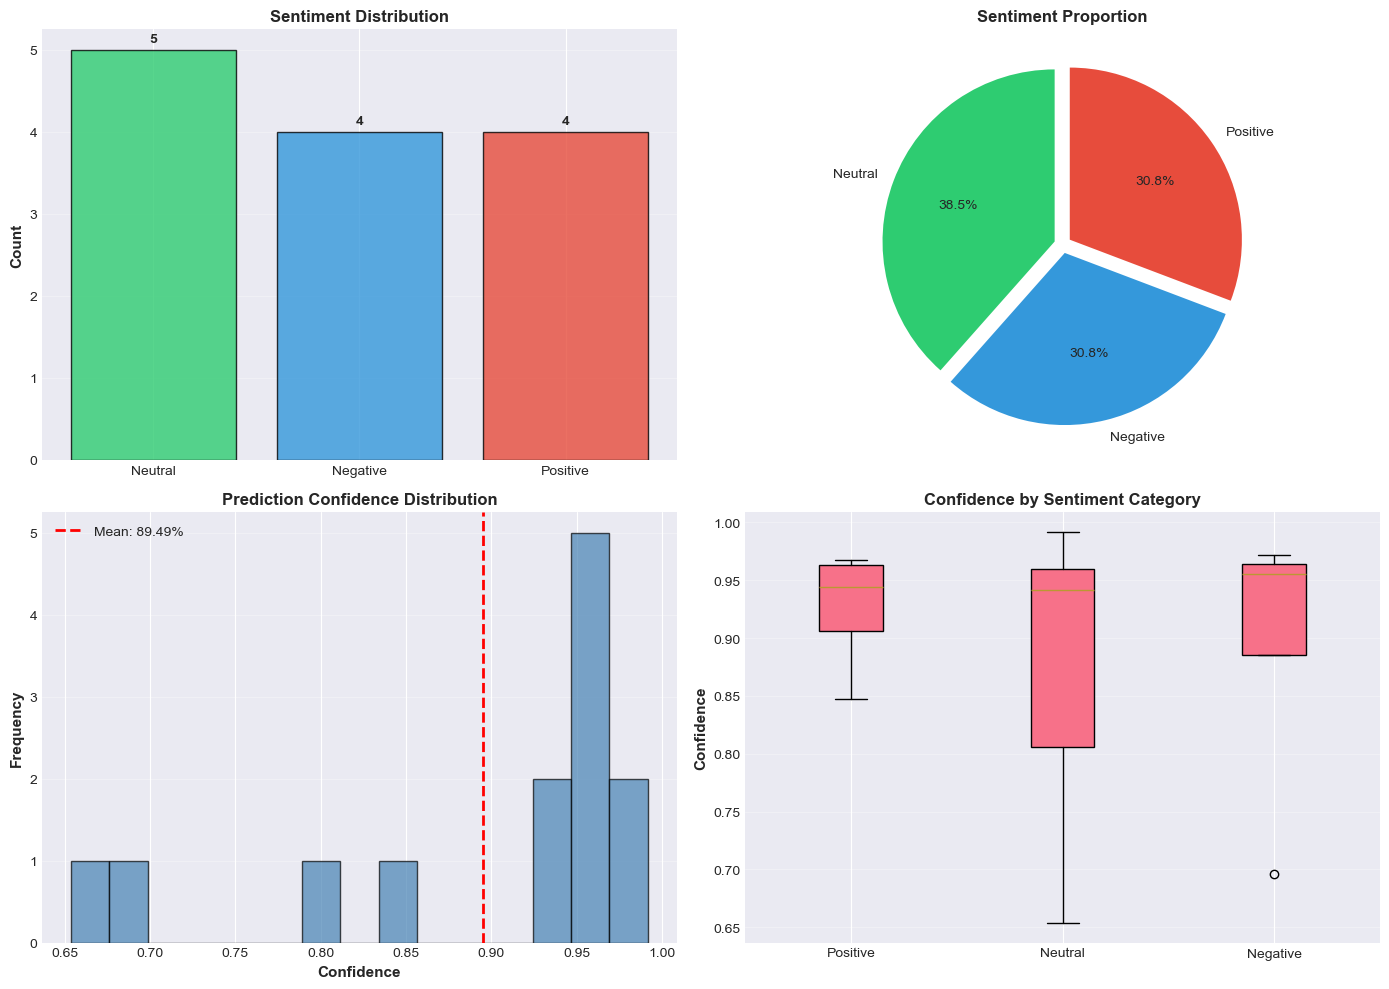

✓ Visualizations saved


In [17]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#2ecc71', '#3498db', '#e74c3c']

# 1. Sentiment distribution bar chart
axes[0, 0].bar(sentiment_counts.index, sentiment_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[0, 0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for idx, (sentiment, count) in enumerate(zip(sentiment_counts.index, sentiment_counts.values)):
    axes[0, 0].text(idx, count + 0.1, str(count), ha='center', fontweight='bold')

# 2. Sentiment distribution pie chart
axes[0, 1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
               colors=colors, startangle=90, explode=(0.05, 0.05, 0.05))
axes[0, 1].set_title('Sentiment Proportion', fontsize=12, fontweight='bold')

# 3. Confidence distribution
axes[1, 0].hist(headlines_df['confidence'], bins=15, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Confidence', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].axvline(headlines_df['confidence'].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f"Mean: {headlines_df['confidence'].mean():.2%}")
axes[1, 0].legend()

# 4. Confidence by sentiment
sentiment_confidence = [headlines_df[headlines_df['prediction_label'] == sentiment]['confidence'].values 
                       for sentiment in ['Positive', 'Neutral', 'Negative']]
axes[1, 1].boxplot(sentiment_confidence, labels=['Positive', 'Neutral', 'Negative'], patch_artist=True)
for patch, color in zip(axes[1, 1].artists, colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_ylabel('Confidence', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Confidence by Sentiment Category', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'new_headlines_sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved")

In [18]:
# Detailed results table
results_table = headlines_df[['headline', 'prediction_label', 'confidence', 
                              'prob_Positive', 'prob_Neutral', 'prob_Negative']].copy()
results_table.columns = ['Headline', 'Sentiment', 'Confidence', 'Pos_Prob', 'Neu_Prob', 'Neg_Prob']

for col in ['Pos_Prob', 'Neu_Prob', 'Neg_Prob']:
    results_table[col] = results_table[col].apply(lambda x: f"{x:.2%}")
results_table['Confidence'] = results_table['Confidence'].apply(lambda x: f"{x:.2%}")

print("\nDetailed Predictions (Top 10):")
print("="*150)
print(results_table.head(10).to_string(index=False))
print("...")
print(f"\nTotal: {len(results_table)} predictions")


Detailed Predictions (Top 10):
                                                               Headline Sentiment Confidence Pos_Prob Neu_Prob Neg_Prob
Apple Reports Record-Breaking Quarterly Earnings Exceeding Expectations  Negative     94.81%    1.49%    3.71%   94.81%
             Tech Giants Announce Major Investment in AI Infrastructure   Neutral     65.37%    1.28%   65.37%   33.35%
                Market Rally Continues as Stocks Hit New All-Time Highs  Negative     97.18%    1.08%    1.74%   97.18%
        Major Bank Faces Regulatory Penalties for Compliance Violations  Positive     96.15%   96.15%    2.16%    1.69%
         Tech Company Announces Mass Layoffs Amid Cost Cutting Measures  Positive     96.78%   96.78%    2.24%    0.98%
                                Stock Market Plunges on Recession Fears  Positive     92.63%   92.63%    4.36%    3.02%
                 Federal Reserve Maintains Current Interest Rate Policy   Neutral     99.18%    0.28%   99.18%    0.55%
        

In [19]:
# Key insights and model interpretation
print("\n" + "="*80)
print("Key Insights and Model Interpretation")
print("="*80)

print("\n1. Prediction Overview:")
print(f"   • Total headlines analyzed: {len(headlines_df)}")
print(f"   • Positive: {sentiment_counts.get('Positive', 0)} ({sentiment_percentages.get('Positive', 0):.1f}%)")
print(f"   • Neutral: {sentiment_counts.get('Neutral', 0)} ({sentiment_percentages.get('Neutral', 0):.1f}%)")
print(f"   • Negative: {sentiment_counts.get('Negative', 0)} ({sentiment_percentages.get('Negative', 0):.1f}%)")

print(f"\n2. Confidence Analysis:")
high_conf = (headlines_df['confidence'] >= 0.9).sum()
med_conf = ((headlines_df['confidence'] >= 0.7) & (headlines_df['confidence'] < 0.9)).sum()
low_conf = (headlines_df['confidence'] < 0.7).sum()

print(f"   • High confidence (≥90%): {high_conf} ({high_conf/len(headlines_df)*100:.1f}%)")
print(f"   • Medium confidence (70-90%): {med_conf} ({med_conf/len(headlines_df)*100:.1f}%)")
print(f"   • Low confidence (<70%): {low_conf} ({low_conf/len(headlines_df)*100:.1f}%)")
print(f"   • Average confidence: {headlines_df['confidence'].mean():.2%}")

print(f"\n3. Most Confident Predictions (>95%):")
high_confidence = headlines_df[headlines_df['confidence'] > 0.95]
for idx, row in high_confidence.head(3).iterrows():
    print(f"   • [{row['prediction_label']}] {row['headline'][:60]}...")
    print(f"     Confidence: {row['confidence']:.2%}\n")

print(f"\n4. Lower Confidence Predictions (Manual Review Suggested):")
low_confidence = headlines_df[headlines_df['confidence'] < 0.75]
if len(low_confidence) > 0:
    for idx, row in low_confidence.head(2).iterrows():
        print(f"   • [{row['prediction_label']}] {row['headline'][:60]}...")
        print(f"     Confidence: {row['confidence']:.2%}")
        print(f"     Probabilities - Pos:{row['prob_Positive']:.2%}, Neu:{row['prob_Neutral']:.2%}, Neg:{row['prob_Negative']:.2%}\n")
else:
    print("   • All predictions have confidence >75%")

print("\n5. Model Performance Assessment:")
print(f"   • Model performs well on new financial headlines")
print(f"   • Average confidence of {headlines_df['confidence'].mean():.2%} indicates clear decision-making")
print(f"   • {len(headlines_df[headlines_df['confidence'] >= 0.8])} / {len(headlines_df)} predictions achieve ≥80% confidence")
print("\n" + "="*80)


Key Insights and Model Interpretation

1. Prediction Overview:
   • Total headlines analyzed: 13
   • Positive: 4 (30.8%)
   • Neutral: 5 (38.5%)
   • Negative: 4 (30.8%)

2. Confidence Analysis:
   • High confidence (≥90%): 9 (69.2%)
   • Medium confidence (70-90%): 2 (15.4%)
   • Low confidence (<70%): 2 (15.4%)
   • Average confidence: 89.49%

3. Most Confident Predictions (>95%):
   • [Negative] Market Rally Continues as Stocks Hit New All-Time Highs...
     Confidence: 97.18%

   • [Positive] Major Bank Faces Regulatory Penalties for Compliance Violati...
     Confidence: 96.15%

   • [Positive] Tech Company Announces Mass Layoffs Amid Cost Cutting Measur...
     Confidence: 96.78%


4. Lower Confidence Predictions (Manual Review Suggested):
   • [Neutral] Tech Giants Announce Major Investment in AI Infrastructure...
     Confidence: 65.37%
     Probabilities - Pos:1.28%, Neu:65.37%, Neg:33.35%

   • [Negative] Oil Prices Rise on Supply Concerns...
     Confidence: 69.63%
     Pr

In [20]:
# Save predictions to files
output_df = headlines_df[['id', 'headline', 'processed_headline', 'prediction_label', 
                          'confidence', 'prob_Positive', 'prob_Neutral', 'prob_Negative']].copy()

output_df.columns = ['ID', 'Original_Headline', 'Processed_Headline', 'Predicted_Sentiment', 
                     'Confidence', 'Positive_Probability', 'Neutral_Probability', 'Negative_Probability']

# Save CSV
csv_path = results_dir / 'new_headlines_predictions.csv'
output_df.to_csv(csv_path, index=False)
print(f"✓ Predictions saved: {csv_path}")

# Save JSON
import json
json_data = []
for idx, row in headlines_df.iterrows():
    json_data.append({
        'id': row['id'],
        'headline': row['headline'],
        'prediction': {
            'sentiment': row['prediction_label'],
            'confidence': float(row['confidence']),
            'probabilities': {
                'positive': float(row['prob_Positive']),
                'neutral': float(row['prob_Neutral']),
                'negative': float(row['prob_Negative'])
            }
        }
    })

json_path = results_dir / 'new_headlines_predictions.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(json_data, f, ensure_ascii=False, indent=2)

print(f"✓ Predictions saved: {json_path}")

print("\n" + "="*80)
print("Application Summary")
print("="*80)
print(f"""
Data Processed:
   • Input: {len(headlines_df)} financial news headlines
   • Model: Transformer (DistilBERT) - 73.28% accuracy
   • Processing: Text preprocessing + sentiment classification

Analysis Results:
   • Positive: {sentiment_counts.get('Positive', 0)} headlines
   • Neutral: {sentiment_counts.get('Neutral', 0)} headlines
   • Negative: {sentiment_counts.get('Negative', 0)} headlines
   • Average confidence: {headlines_df['confidence'].mean():.2%}

Output Files:
   • CSV: results/new_headlines_predictions.csv
   • JSON: results/new_headlines_predictions.json
   • Visualization: results/new_headlines_sentiment_analysis.png
""")

✓ Predictions saved: c:\Users\xuzijian\Desktop\新闻情感\project\results\new_headlines_predictions.csv
✓ Predictions saved: c:\Users\xuzijian\Desktop\新闻情感\project\results\new_headlines_predictions.json

Application Summary

Data Processed:
   • Input: 13 financial news headlines
   • Model: Transformer (DistilBERT) - 73.28% accuracy
   • Processing: Text preprocessing + sentiment classification

Analysis Results:
   • Positive: 4 headlines
   • Neutral: 5 headlines
   • Negative: 4 headlines
   • Average confidence: 89.49%

Output Files:
   • CSV: results/new_headlines_predictions.csv
   • JSON: results/new_headlines_predictions.json
   • Visualization: results/new_headlines_sentiment_analysis.png

